<a href="https://colab.research.google.com/github/CristinaMarsh/100-Days-Of-ML-Code/blob/master/Experiment/Deep_Convolutional_Generative_Adversarial_Network.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:

!pip install tensorflow-addons

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.1 MB 14.4 MB/s 


thanks https://github.com/wcswcswcs/gans_finance/blob/main/GANs_for_time_series_Eckerli.ipynb

In [1]:
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow.keras import layers
import time
import tensorflow as tf
import tensorflow_addons as tfa

from IPython import display
tf.__version__

'2.8.2'

In [2]:
# Specific for real data
#BUFFER_SIZE = 5032 # lenght of timeseries 
BUFFER_SIZE = 1520 
BATCH_SIZE = 32 
data_dim = 32 
noise_dim = 100
data_channel = 1

In [3]:
# must be from ['dcgan', 'lsgan', 'sagan', 'wgan', 'wgan_gp', 'dragan', 'ragan', 'ralsgan', 'ylgan', 'biggan', 'biggan_deep', 'transgan']
# 'dcgan': standard deep convolutional GAN
# 'lsgan': least square GAN, a loss variant
# 'sagan': self-attention GAN, a structure variant with dense attention
# 'wgan': Wasserstein GAN, a loss variant
# 'wgan_gp': Wasserstein GAN with gradient penalty, a loss variant
# 'dragan': deep regret analytic GAN, a loss variant similar to 'wgan_gp'
# 'ragan', 'ralsgan': loss function improvements of 'dcgan' and 'lsgan' with realistic factors
# 'ylgan': your local GAN, a structure variant with sparse attention
# 'biggan', 'biggan_deep': larger versions of 'sagan'
# 'transgan': transformer GAN, a strucutre variant with transformer blocks


choice = 'dcgan'

In [4]:
# self defined layers
# residual link used in attention
class ResidualLink(layers.Layer):
    def __init__(self):
      super(ResidualLink, self).__init__()
    def build(self, input_shape):  
      self.sigma = tf.Variable(0.0, trainable=True)
    def call(self, x, attn):  
      return x + self.sigma * attn

# position embedding in transformers      
class PosEmbed(layers.Layer):
  def __init__(self):
    super(PosEmbed, self).__init__()
  def build(self, input_shape):  
    _, location_num, num_channels = input_shape.as_list()
    self.paras = tf.Variable(tf.random.truncated_normal([1,location_num, num_channels], stddev=0.02), trainable=True)
  def call(self, inputs):  
    return inputs + self.paras

# not used
class CloseToken(layers.Layer):
  def __init__(self):
    super(CloseToken, self).__init__()
  def build(self, input_shape):  
    _, location_num, num_channels = input_shape.as_list()
    paras = tf.Variable(tf.random.truncated_normal([1,1,num_channels], stddev=0.02), trainable=True)
    self.paras = tf.pad(paras, tf.constant([[0, 0,], [0, location_num], [0, 0]]), "CONSTANT")
  def call(self, inputs):  
    return tf.pad(inputs, tf.constant([[0, 0,], [1, 0], [0, 0]]), "CONSTANT") + self.paras

# attention block, used in SAGAN and BigGAN
def attn_block(x, hidden_ratio, g_ratio, **kwargs):
    num_channels = x.get_shape().as_list()[-1]
    theta = tfa.layers.SpectralNormalization(layers.Conv1D(num_channels // hidden_ratio, 1, strides=1, padding='same', **kwargs))(x) 
    phi = tfa.layers.SpectralNormalization(layers.Conv1D(num_channels // hidden_ratio, 1, strides=1, padding='same', **kwargs))(x)
    phi = tf.keras.layers.MaxPooling1D(pool_size=2, strides=2, padding="valid")(phi)
    attn = tf.matmul(theta, phi, transpose_b=True)
    attn = tf.nn.softmax(attn)
    g = tfa.layers.SpectralNormalization(layers.Conv1D(num_channels // g_ratio, 1, strides=1, padding='same', **kwargs))(x)
    g = tf.keras.layers.MaxPooling1D(pool_size=2, strides=2, padding="valid")(g)
    attn_g = tf.matmul(attn, g)
    attn_g = tfa.layers.SpectralNormalization(layers.Conv1D(num_channels, 1, strides=1, padding='same', **kwargs))(attn_g)
    return ResidualLink()(x, attn_g)

# multi-head attention block, used in YLGAN and TransGAN, supports sparse attention
def multi_head_attn_block(x, hidden_ratio, g_ratio, nH, sparse, **kwargs):
    def sparse_mask(long, short, kind):
        '''
        mask for sparse attention, 
        kind from LeftFloorMask, RightFloorMask, LeftRepetitiveMask and RightRepetitiveMask, 
        used in Your Local GAN
        '''
        stride = int(np.sqrt(short))
        assert long % short == 0
        multiple = long//short
        if kind in ['LeftFloorMask', 'RightFloorMask']:
            indices = []
            for row in range(short):
                for col in range(row - (row % stride), row + 1):
                    indices.append([row, col])
            indices = np.array(indices)
            mask = np.zeros([short, short], dtype=np.bool)
            if kind == 'LeftFloorMask':          
                mask[indices[:, 0], indices[:, 1]] = True 
            else:   
                mask[indices[:, 1], indices[:, 0]] = True 

        if kind in ['LeftRepetitiveMask', 'RightRepetitiveMask']:
            if kind == 'RightRepetitiveMask':
                col_indices = np.arange(0,short,stride)
            else:
                col_indices = np.arange(stride - 1,short,stride)
            mask = np.eye(short, dtype=bool)
            for col in col_indices:
                mask[:,col] = True
        return np.vstack([mask]*multiple)

    def get_grid_masks(long, short):
        return np.array([sparse_mask(long,short,'RightFloorMask'),
        sparse_mask(long,short,'LeftFloorMask'),
        sparse_mask(long,short,'RightRepetitiveMask'),
        sparse_mask(long,short,'LeftRepetitiveMask')])

    _, location_num, num_channels = x.shape.as_list()
    assert num_channels % (hidden_ratio*nH) == 0       
    downsampled_num = location_num // 2
    hidden_size = num_channels // hidden_ratio             
    head_size = hidden_size // nH # size_per_head        

    # theta path
    theta = tfa.layers.SpectralNormalization(layers.Conv1D(hidden_size, 1, strides=1, padding='same', **kwargs))(x)
    theta = tf.reshape(theta, [-1, location_num, nH, head_size])
    theta = tf.transpose(theta, [0, 2, 1, 3])

    # phi path
    phi = tfa.layers.SpectralNormalization(layers.Conv1D(hidden_size, 1, strides=1, padding='same', **kwargs))(x)
    phi = tf.keras.layers.MaxPooling1D(pool_size=2, strides=2, padding="valid")(phi)
    phi = tf.reshape(phi, [-1, downsampled_num, nH, head_size])       
    phi = tf.transpose(phi, [0, 2, 1, 3])

    attn = tf.matmul(theta, phi, transpose_b=True)
    if sparse:
      masks = tf.constant(get_grid_masks(location_num, downsampled_num)) # acquire masks
      attn = tf.keras.layers.Softmax()(attn, masks)
    else:
      attn = tf.keras.layers.Softmax()(attn)

    # g path
    g_hidden = num_channels // g_ratio
    g_head_size = g_hidden // nH
    g = tfa.layers.SpectralNormalization(layers.Conv1D(g_hidden, 1, strides=1, padding='same', **kwargs))(x)
    g = tf.keras.layers.MaxPooling1D(pool_size=2, strides=2, padding="valid")(g)
    g = tf.reshape(g, [-1, downsampled_num, nH, g_head_size])
    # swap for heads
    g = tf.transpose(g, [0, 2, 1, 3])

    attn_g = tf.matmul(attn, g)
    # put heads to the end
    attn_g = tf.transpose(attn_g, [0, 2, 3, 1])
    attn_g = tf.reshape(attn_g, [-1, location_num, g_hidden])
    attn_g = tfa.layers.SpectralNormalization(layers.Conv1D(num_channels, 1, strides=1, padding='same', **kwargs))(attn_g)
    return ResidualLink()(x, attn_g)

def usample(x):
    x = layers.UpSampling1D(size=2)(x)
    return x

# ResNet generator block, used in SAGAN, etc.
def G_res_block(x, out_channels, g_kernel, **kwargs):
    x_0 = x
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x) 
    x = usample(x)
    x = tfa.layers.SpectralNormalization(layers.Conv1D(out_channels, g_kernel, strides=1, padding='same', **kwargs))(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x) 
    x = tfa.layers.SpectralNormalization(layers.Conv1D(out_channels, g_kernel, strides=1, padding='same', **kwargs))(x)    
    x_0 = usample(x_0)
    x_0 = tfa.layers.SpectralNormalization(layers.Conv1D(out_channels, 1, strides=1, padding='same', **kwargs))(x_0)  
    return x_0 + x

# ResNet generator bottleneck structure
def G_res_bottleneck_block(x, out_channels, g_kernel, upsample, hidden_ratio, **kwargs):
    num_channels = x.get_shape().as_list()[-1]
    hidden_size = num_channels // hidden_ratio
    x_0 = x
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x) 
    x = tfa.layers.SpectralNormalization(layers.Conv1D(hidden_size, 1, strides=1, padding='same', **kwargs))(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)    
    if upsample:
      x = usample(x)
    x = tfa.layers.SpectralNormalization(layers.Conv1D(hidden_size, g_kernel, strides=1, padding='same', **kwargs))(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x) 
    x = tfa.layers.SpectralNormalization(layers.Conv1D(hidden_size, g_kernel, strides=1, padding='same', **kwargs))(x)    
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x) 
    x = tfa.layers.SpectralNormalization(layers.Conv1D(out_channels, 1, strides=1, padding='same', **kwargs))(x)    
    if out_channels < num_channels:
      x_0 = x_0[:,:,:out_channels]
    if upsample:
      x_0 = usample(x_0)
    return x_0 + x

# ResNet generator output layer
def G_out_sn_block(x, out_channels, g_kernel, **kwargs):
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x) 
    x = tfa.layers.SpectralNormalization(layers.Conv1D(out_channels, g_kernel, strides=1, padding='same', **kwargs))(x)
    return x

def dsample(x):
    return layers.AveragePooling1D(pool_size=2, padding='valid')(x)

# ResNet discrinimtor start block
def D_res_start_block(x, out_channels, d_kernel, **kwargs):
    x_0 = x
    x = tfa.layers.SpectralNormalization(layers.Conv1D(out_channels, d_kernel, strides=1, padding='same', **kwargs))(x)
    x = layers.LeakyReLU()(x) 
    x = tfa.layers.SpectralNormalization(layers.Conv1D(out_channels, d_kernel, strides=2, padding='same', **kwargs))(x)
    # x = dsample(x) 
    x_0 = tfa.layers.SpectralNormalization(layers.Conv1D(out_channels, 2, strides=2, padding='same', **kwargs))(x_0)  
    # x_0 = dsample(x_0) ## change position          
    return x + x_0

# ResNet discrinimtor block    
def D_res_block(x, out_channels, d_kernel, **kwargs):
    x_0 = x
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU()(x)
    x = tfa.layers.SpectralNormalization(layers.Conv1D(out_channels, d_kernel, strides=1, padding='same', **kwargs))(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU()(x)
    x = tfa.layers.SpectralNormalization(layers.Conv1D(out_channels, d_kernel, strides=2, padding='same', **kwargs))(x)
    # x = dsample(x)
    x_0 = tfa.layers.SpectralNormalization(layers.Conv1D(out_channels, 2, strides=2, padding='same', **kwargs))(x_0)
    # x_0 = dsample(x_0)
    return x_0 + x

# ResNet discrinimtor bottleneck block 
def D_res_bottleneck_block(x, out_channels, d_kernel, downsample, hidden_ratio, **kwargs):
    num_channels = x.get_shape().as_list()[-1]
    hidden_size = num_channels // hidden_ratio
    strd = 2 if downsample else 1
    x_0 = x
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU()(x)
    x = tfa.layers.SpectralNormalization(layers.Conv1D(hidden_size, 1, strides=1, padding='same', **kwargs))(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU()(x)
    x = tfa.layers.SpectralNormalization(layers.Conv1D(hidden_size, d_kernel, strides=1, padding='same', **kwargs))(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU()(x)
    x = tfa.layers.SpectralNormalization(layers.Conv1D(hidden_size, d_kernel, strides=strd, padding='same', **kwargs))(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU()(x)
    x = tfa.layers.SpectralNormalization(layers.Conv1D(out_channels, 1, strides=1, padding='same', **kwargs))(x)
    if downsample: 
      x_0 = dsample(x_0)
    if out_channels > num_channels:
      x_c = tfa.layers.SpectralNormalization(layers.Conv1D(out_channels-num_channels, 1, strides=1, padding='same', **kwargs))(x_0)
      x_0 = tf.concat([x_0,x_c],axis=-1)
    return x_0 + x

# ResNet discrinimtor last block
def D_res_keep_block(x, d_kernel, **kwargs):
    input_channels = x.shape.as_list()[-1]
    x_0 = x
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU()(x)
    x = tfa.layers.SpectralNormalization(layers.Conv1D(input_channels, d_kernel, strides=1, padding='same', **kwargs))(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU()(x)
    x = tfa.layers.SpectralNormalization(layers.Conv1D(input_channels, d_kernel, strides=1, padding='same', **kwargs))(x)
    return x_0 + x

# G and D blocks without residual layers
def G_single_block(model, out_channels, g_kernel, act, **kwargs):
    model.add(layers.BatchNormalization())
    model.add(act())
    model.add(layers.Conv1DTranspose(out_channels, g_kernel, strides=2, padding='same', **kwargs))

def D_single_block(model, out_channels, d_kernel, **kwargs):
    model.add(layers.Conv1D(out_channels, d_kernel, strides=2, padding='same', use_bias=False, **kwargs))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

# regularizer used in BigGAN
def orthogonal_reg(w, beta=1e-4):
    w = tf.reshape(w,[-1, w.shape[-1]])
    if w.shape[0]<w.shape[1]:
      mat = tf.matmul(w,tf.transpose(w))*(1-tf.eye(w.shape[0]))
    else:
      mat = tf.matmul(tf.transpose(w),w)*(1-tf.eye(w.shape[1]))
    return beta * tf.reduce_sum(mat**2)

In [5]:
def make_generator_model(choice = 'sagan'):
    if choice == 'sagan':
        g_kernel = 5
        gf_dim = 8
        inputs = layers.Input(shape= (noise_dim,))
        x = tfa.layers.SpectralNormalization(layers.Dense(data_dim*gf_dim, input_shape=(noise_dim,)))(inputs)
        x = layers.Reshape((data_dim//16, gf_dim * 16))(x)
        x = G_res_block(x, gf_dim*8, g_kernel) # data_dim //8
        x = G_res_block(x, gf_dim*4, g_kernel) # data_dim //4
        x = attn_block(x, hidden_ratio=8, g_ratio=2) # data_dim //4
        x = G_res_block(x, gf_dim*2, g_kernel) # data_dim //2  
        x = G_res_block(x, gf_dim, g_kernel) # data_dim   
        y = G_out_sn_block(x, data_channel, g_kernel) # data_dim
        model = tf.keras.Model(inputs, y)

    elif choice == 'biggan':
        g_kernel = 5
        gf_dim = 8
        additional = {'kernel_initializer': tf.keras.initializers.Orthogonal(),
                'kernel_regularizer': orthogonal_reg}
        inputs = layers.Input(shape= (noise_dim,))
        x = tfa.layers.SpectralNormalization(layers.Dense(data_dim*gf_dim, input_shape=(noise_dim,), **additional))(inputs)
        x = layers.Reshape((data_dim//16, gf_dim * 16))(x)
        x = G_res_block(x, gf_dim*8, g_kernel, **additional) # data_dim //8
        x = G_res_block(x, gf_dim*4, g_kernel, **additional) # data_dim //4
        x = attn_block(x, hidden_ratio=8, g_ratio=2, **additional) # data_dim //4
        x = G_res_block(x, gf_dim*2, g_kernel, **additional) # data_dim //2  
        x = G_res_block(x, gf_dim, g_kernel, **additional) # data_dim   
        y = G_out_sn_block(x, data_channel, g_kernel, **additional) # data_dim
        model = tf.keras.Model(inputs, y)

    elif choice == 'biggan_deep':
        g_kernel = 5
        gf_dim = 8
        additional = {'kernel_initializer': tf.keras.initializers.Orthogonal(),
                'kernel_regularizer': orthogonal_reg}
        inputs = layers.Input(shape= (noise_dim,))
        x = tfa.layers.SpectralNormalization(layers.Dense(data_dim*gf_dim, input_shape=(noise_dim,), **additional))(inputs)
        x = layers.Reshape((data_dim//16, gf_dim * 16))(x)
        x = G_res_bottleneck_block(x, gf_dim*16, g_kernel, upsample=False, hidden_ratio=4, **additional)
        x = G_res_bottleneck_block(x, gf_dim*8, g_kernel, upsample=True, hidden_ratio=4, **additional) # data_dim //8
        x = G_res_bottleneck_block(x, gf_dim*8, g_kernel, upsample=False, hidden_ratio=4, **additional)
        x = G_res_bottleneck_block(x, gf_dim*4, g_kernel, upsample=True, hidden_ratio=4, **additional) # data_dim //4
        x = attn_block(x, hidden_ratio=8, g_ratio=2, **additional) # data_dim //4
        x = G_res_bottleneck_block(x, gf_dim*4, g_kernel, upsample=False, hidden_ratio=4, **additional)
        x = G_res_bottleneck_block(x, gf_dim*2, g_kernel, upsample=True, hidden_ratio=4, **additional) # data_dim //2
        x = G_res_bottleneck_block(x, gf_dim*2, g_kernel, upsample=False, hidden_ratio=4, **additional)
        x = G_res_bottleneck_block(x, gf_dim, g_kernel, upsample=True, hidden_ratio=4, **additional) # data_dim
        y = G_out_sn_block(x, data_channel, g_kernel, **additional) # data_dim
        model = tf.keras.Model(inputs, y)

    elif choice == 'ylgan':
        g_kernel = 5
        gf_dim = 8
        inputs = layers.Input(shape= (noise_dim,))
        x = tfa.layers.SpectralNormalization(layers.Dense(data_dim*gf_dim, input_shape=(noise_dim,)))(inputs)
        x = layers.Reshape((data_dim//16, gf_dim * 16))(x)
        x = G_res_block(x, gf_dim*8, g_kernel) # data_dim //8
        x = G_res_block(x, gf_dim*4, g_kernel) # data_dim //4
        x = multi_head_attn_block(x, hidden_ratio=4, g_ratio=2, nH=4, sparse=True) # data_dim //4
        x = G_res_block(x, gf_dim*2, g_kernel) # data_dim //2  
        x = G_res_block(x, gf_dim, g_kernel) # data_dim   
        y = G_out_sn_block(x, data_channel, g_kernel) # data_dim
        model = tf.keras.Model(inputs, y)

    elif choice == 'transgan':
        def mlp_block(x, ratio=4):
          x0 = x
          num_channels = x.shape[-1]
          x = tfa.layers.SpectralNormalization(layers.Conv1D(num_channels * ratio, 1, strides=1, padding='same'))(x)
          x = tf.keras.activations.gelu(x)
          x = tfa.layers.SpectralNormalization(layers.Conv1D(num_channels, 1, strides=1, padding='same'))(x)
          return x0 + x
        def block(x):
          x = layers.LayerNormalization()(x)
          x = multi_head_attn_block(x, hidden_ratio=2, g_ratio=2, nH=4, sparse=False)
          x = layers.LayerNormalization()(x)
          x = mlp_block(x)           
          return x
        def up_sampling(x):
          _, location_num, num_channels = x.shape.as_list()
          return tf.reshape(x, [-1, location_num*2, num_channels//2])
        gf_dim = 16
        inputs = layers.Input(shape= (noise_dim,))
        x = tfa.layers.SpectralNormalization(layers.Dense(data_dim*gf_dim, input_shape=(noise_dim,)))(inputs)
        x = layers.Reshape((data_dim//4, gf_dim*4))(x)
        x = PosEmbed()(x) 
        x = block(x)  
        x = up_sampling(x) 
        x = PosEmbed()(x) 
        x = block(x)
        x = up_sampling(x) 
        x = PosEmbed()(x) 
        x = block(x)
        y = tfa.layers.SpectralNormalization(layers.Conv1D(data_channel, 1, strides=1, padding='same'))(x)
        model = tf.keras.Model(inputs, y)
 
    elif choice in ['sn_lsgan', 'sn_dcgan']: 
        g_kernel = 5
        gf_dim = 32
        act = layers.LeakyReLU
        def block(model, out_channels):
          model.add(layers.BatchNormalization())
          model.add(act())
          model.add(tfa.layers.SpectralNormalization(layers.Conv1DTranspose(out_channels, g_kernel, strides=2, padding='same')))

        model = tf.keras.Sequential()
        model.add(tfa.layers.SpectralNormalization(layers.Dense(data_dim * gf_dim, input_shape=(noise_dim,))))
        model.add(layers.Reshape((data_dim//8, gf_dim*8)))

        # block(model, gf_dim*8)
        block(model, gf_dim*4)
        block(model, gf_dim*2)
        block(model, gf_dim)

        model.add(layers.BatchNormalization())
        model.add(act())
        model.add(tfa.layers.SpectralNormalization(layers.Conv1DTranspose(data_channel, g_kernel, strides=1, padding='same', activation= 'linear')))
        
    elif choice in ['lsgan', 'dcgan', 'wgan_gp', 'dragan', 'ragan', 'ralsgan']:
        g_kernel = 5
        gf_dim = 32
        act = layers.LeakyReLU

        model = tf.keras.Sequential()
        model.add(layers.Dense(data_dim * gf_dim, input_shape=(noise_dim,)))
        model.add(layers.Reshape((data_dim//8, gf_dim*8)))

        G_single_block(model, gf_dim*4, g_kernel, act)
        G_single_block(model, gf_dim*2, g_kernel, act)
        G_single_block(model, gf_dim, g_kernel, act)
        
        model.add(layers.BatchNormalization())
        model.add(act())
        model.add(layers.Conv1DTranspose(data_channel, g_kernel, strides=1, padding='same', activation= 'linear'))

    elif choice == 'wgan':
        g_kernel = 5
        gf_dim = 32
        act = layers.LeakyReLU
        additional = {'kernel_initializer': tf.random_normal_initializer(stddev=0.02)}

        model = tf.keras.Sequential()
        model.add(layers.Dense(data_dim * gf_dim, input_shape=(noise_dim,), **additional))
        model.add(layers.Reshape((data_dim//8, gf_dim*8)))

        G_single_block(model, gf_dim*4, g_kernel, act, **additional)
        G_single_block(model, gf_dim*2, g_kernel, act, **additional)
        G_single_block(model, gf_dim, g_kernel, act, **additional)
        
        model.add(layers.BatchNormalization())
        model.add(act())
        model.add(layers.Conv1DTranspose(data_channel, g_kernel, strides=1, padding='same', activation= 'linear', **additional))
    
    return model

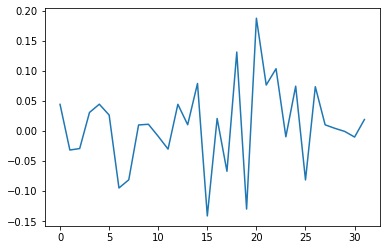

In [6]:
generator = make_generator_model(choice)

noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

plt.plot(generated_image[0, :, 0])

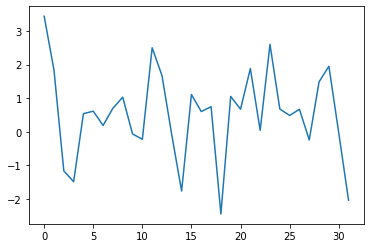

In [72]:
generator = make_generator_model('transgan')

noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

plt.plot(generated_image[0, :, 0])

In [44]:
157*32

5024

In [9]:
generator.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 100)]        0           []                               
                                                                                                  
 spectral_normalization (Spectr  (None, 512)         52224       ['input_1[0][0]']                
 alNormalization)                                                                                 
                                                                                                  
 reshape_1 (Reshape)            (None, 8, 64)        0           ['spectral_normalization[0][0]'] 
                                                                                                  
 pos_embed (PosEmbed)           (None, 8, 64)        512         ['reshape_1[0][0]']          

In [7]:
def make_discriminator_model(choice = 'sagan'):
    if choice == 'sagan':
        d_kernel = 5        
        df_dim = 8
        inputs = layers.Input(shape= (data_dim, data_channel))
        x = D_res_start_block(inputs, df_dim, d_kernel)  # df_dim//2
        x = D_res_block(x, df_dim * 2, d_kernel)  # df_dim//4
        x = attn_block(x, hidden_ratio=8, g_ratio=2)  # df_dim//4
        x = D_res_block(x, df_dim * 4, d_kernel)  # df_dim//8
        x = D_res_block(x, df_dim * 8, d_kernel)  # df_dim//16
        x = D_res_block(x, df_dim * 16, d_kernel)  # df_dim//32
        x = D_res_keep_block(x, d_kernel)
        x = layers.BatchNormalization()(x)
        x = layers.LeakyReLU()(x)
        x = tf.reduce_sum(x, [1])
        y = tfa.layers.SpectralNormalization(layers.Dense(1))(x)
        model = tf.keras.Model(inputs, y)

    elif choice == 'biggan':
        d_kernel = 5        
        df_dim = 8
        additional = {'kernel_initializer': tf.keras.initializers.Orthogonal(),
                'kernel_regularizer': orthogonal_reg}
        inputs = layers.Input(shape= (data_dim, data_channel))
        x = D_res_start_block(inputs, df_dim, d_kernel, **additional)  # df_dim//2
        x = D_res_block(x, df_dim * 2, d_kernel, **additional)  # df_dim//4
        x = attn_block(x, hidden_ratio=8, g_ratio=2, **additional)  # df_dim//4
        x = D_res_block(x, df_dim * 4, d_kernel, **additional)  # df_dim//8
        x = D_res_block(x, df_dim * 8, d_kernel, **additional)  # df_dim//16
        x = D_res_block(x, df_dim * 16, d_kernel, **additional)  # df_dim//32
        x = D_res_keep_block(x, d_kernel, **additional)
        x = layers.BatchNormalization()(x)
        x = layers.LeakyReLU()(x)
        x = tf.reduce_sum(x, [1])
        y = tfa.layers.SpectralNormalization(layers.Dense(1,**additional))(x)
        model = tf.keras.Model(inputs, y)

    elif choice == 'biggan_deep':
        d_kernel = 5        
        df_dim = 8
        additional = {'kernel_initializer': tf.keras.initializers.Orthogonal(),
                'kernel_regularizer': orthogonal_reg}
        inputs = layers.Input(shape= (data_dim, data_channel))
        x = tfa.layers.SpectralNormalization(layers.Conv1D(df_dim, d_kernel, strides=1, padding='same', **additional))(inputs)  
        x = D_res_bottleneck_block(x, df_dim, d_kernel, downsample=True, hidden_ratio=2, **additional)  # df_dim//2
        x = D_res_bottleneck_block(x, df_dim * 2, d_kernel, downsample=False, hidden_ratio=2, **additional)  # df_dim//2
        x = D_res_bottleneck_block(x, df_dim * 2, d_kernel, downsample=True, hidden_ratio=2, **additional)  # df_dim//4
        x = D_res_bottleneck_block(x, df_dim * 4, d_kernel, downsample=False, hidden_ratio=2, **additional)  # df_dim//4
        x = attn_block(x, hidden_ratio=8, g_ratio=2, **additional)  # df_dim//4
        x = D_res_bottleneck_block(x, df_dim * 4, d_kernel, downsample=True, hidden_ratio=2, **additional)  # df_dim//8
        x = D_res_bottleneck_block(x, df_dim * 8, d_kernel, downsample=False, hidden_ratio=2, **additional)  # df_dim//8
        x = D_res_bottleneck_block(x, df_dim * 8, d_kernel, downsample=True, hidden_ratio=2, **additional)  # df_dim//16
        x = D_res_bottleneck_block(x, df_dim * 16, d_kernel, downsample=False, hidden_ratio=2, **additional)  # df_dim//16
        x = D_res_bottleneck_block(x, df_dim * 16, d_kernel, downsample=False, hidden_ratio=2, **additional)  # df_dim//16
        x = D_res_bottleneck_block(x, df_dim * 16, d_kernel, downsample=False, hidden_ratio=2, **additional)  # df_dim//16
        x = layers.BatchNormalization()(x)
        x = layers.LeakyReLU()(x)
        x = tf.reduce_sum(x, [1])
        y = tfa.layers.SpectralNormalization(layers.Dense(1,**additional))(x)
        model = tf.keras.Model(inputs, y)
                     
    elif choice == 'ylgan':
        d_kernel = 5
        df_dim = 8
        inputs = layers.Input(shape= (data_dim, data_channel))
        x = D_res_start_block(inputs, df_dim, d_kernel)  # df_dim//2
        x = D_res_block(x, df_dim * 2, d_kernel)  # df_dim//4
        x = multi_head_attn_block(x, hidden_ratio=4, g_ratio=2, nH=4, sparse=True)  # df_dim//4
        x = D_res_block(x, df_dim * 4, d_kernel)  # df_dim//8
        x = D_res_block(x, df_dim * 8, d_kernel)  # df_dim//16
        x = D_res_block(x, df_dim * 16, d_kernel)  # df_dim//32
        x = D_res_keep_block(x, d_kernel)
        x = layers.BatchNormalization()(x)
        x = layers.LeakyReLU()(x)
        x = tf.reduce_sum(x, [1])
        y = tfa.layers.SpectralNormalization(layers.Dense(1))(x)
        model = tf.keras.Model(inputs, y)

    elif choice == 'transgan':
        def mlp_block(x, ratio=4):
          x0 = x
          num_channels = x.shape[-1]
          x = tfa.layers.SpectralNormalization(layers.Conv1D(num_channels * ratio, 1, strides=1, padding='same'))(x)
          x = tf.keras.activations.gelu(x)
          x = tfa.layers.SpectralNormalization(layers.Conv1D(num_channels, 1, strides=1, padding='same'))(x)
          return x0 + x
        def block(x):
          x = layers.LayerNormalization()(x)
          x = multi_head_attn_block(x, hidden_ratio=2, g_ratio=2, nH=4, sparse=False)
          x = layers.LayerNormalization()(x)
          x = mlp_block(x)           
          return x
        def down_sampling(x):
          _, location_num, num_channels = x.shape.as_list()
          return tf.reshape(x, [-1, location_num//2, num_channels*2])
        df_dim = 64
        inputs = layers.Input(shape= (data_dim, data_channel))
        x = tfa.layers.SpectralNormalization(layers.Conv1D(df_dim, 1, strides=1, padding='same'))(inputs)
        # x = CloseToken()(x) 
        x = PosEmbed()(x)  
        x = block(x)  
        x = block(x) 
        x = block(x)
        x = layers.LayerNormalization()(x)
        # x = tf.reduce_mean(x, [1])
        x = tf.keras.layers.Flatten()(x)
        y = tfa.layers.SpectralNormalization(layers.Dense(1))(x)
        model = tf.keras.Model(inputs, y)
    
    elif choice in ['sn_lsgan', 'sn_dcgan']:
        d_kernel = 5
        df_dim = 32
        def block(model, out_channels):
          model.add(tfa.layers.SpectralNormalization(layers.Conv1D(out_channels, d_kernel, strides=2, padding='same')))
          model.add(layers.BatchNormalization())
          model.add(layers.LeakyReLU())

        model = tf.keras.Sequential()
        model.add(layers.InputLayer(input_shape=(data_dim, data_channel)))
        model.add(tfa.layers.SpectralNormalization(layers.Conv1D(df_dim, d_kernel, strides=2, padding='same')))
        model.add(layers.LeakyReLU())

        block(model, df_dim*2)        
        block(model, df_dim*4)
        # block(model, df_dim*8)
        
        model.add(layers.Flatten())
        model.add(tfa.layers.SpectralNormalization(layers.Dense(1)))

    elif choice in ['lsgan', 'dcgan', 'wgan_gp', 'dragan', 'ragan', 'ralsgan']:
        d_kernel = 5
        df_dim = 32

        model = tf.keras.Sequential()
        model.add(layers.InputLayer(input_shape=(data_dim, data_channel)))
        model.add(layers.Conv1D(df_dim, d_kernel, strides=2, padding='same'))
        model.add(layers.LeakyReLU())

        D_single_block(model, df_dim*2, d_kernel)
        D_single_block(model, df_dim*4, d_kernel)
        
        model.add(layers.Flatten())
        model.add(layers.Dense(1, use_bias=False))

    elif choice == 'wgan':
        d_kernel = 5
        df_dim = 32
        additional = {'kernel_initializer': tf.random_normal_initializer(stddev=0.02),
                'kernel_constraint': lambda w: tf.clip_by_value(w,-0.01,0.01)}

        model = tf.keras.Sequential()
        model.add(layers.InputLayer(input_shape=(data_dim, data_channel)))
        model.add(layers.Conv1D(df_dim, d_kernel, strides=2, padding='same', **additional))
        model.add(layers.LeakyReLU())

        D_single_block(model, df_dim*2, d_kernel, **additional)
        D_single_block(model, df_dim*4, d_kernel, **additional)
        
        model.add(layers.Flatten())
        model.add(layers.Dense(1, use_bias=False, **additional))

    return model

In [8]:
discriminator = make_discriminator_model(choice)
decision = discriminator(generated_image)
print (decision)

tf.Tensor([[0.00937707]], shape=(1, 1), dtype=float32)


In [75]:
discriminator.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_41 (Conv1D)          (None, 16, 32)            192       
                                                                 
 leaky_re_lu_11 (LeakyReLU)  (None, 16, 32)            0         
                                                                 
 conv1d_42 (Conv1D)          (None, 8, 64)             10240     
                                                                 
 batch_normalization_10 (Bat  (None, 8, 64)            256       
 chNormalization)                                                
                                                                 
 leaky_re_lu_12 (LeakyReLU)  (None, 8, 64)             0         
                                                                 
 conv1d_43 (Conv1D)          (None, 4, 128)            40960     
                                                      

## Define the loss and optimizers
Define loss functions and optimizers for both models.

In [9]:
# This method returns a helper function to compute cross entropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def ls_loss(a,b):
  return tf.reduce_mean(tf.nn.l2_loss(a - b)) 

### Discriminator loss

In [10]:
def discriminator_loss(real_output, fake_output, choice = 'sagan', generated_images = None, images= None):
    if choice in ['sagan','ylgan','biggan','biggan_deep']: # hinge loss
        real_loss = tf.reduce_mean(tf.nn.relu(1.0 - real_output))
        fake_loss = tf.reduce_mean(tf.nn.relu(1.0 + fake_output))
        total_loss = real_loss + fake_loss
    elif choice == 'transgan':
        real_loss = tf.reduce_mean(tf.nn.relu(1.0 - real_output))
        fake_loss = tf.reduce_mean(tf.nn.relu(1.0 + fake_output))
        total_loss = real_loss + fake_loss
    elif choice == 'lsgan': # LS loss
        real_loss = ls_loss(tf.ones_like(real_output), real_output) 
        fake_loss = ls_loss(-tf.ones_like(fake_output), fake_output)
        total_loss = real_loss + fake_loss
    elif choice == 'dcgan': # standard loss
        real_loss = cross_entropy(tf.ones_like(real_output), real_output) 
        fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
        total_loss = real_loss + fake_loss
    elif choice == 'ragan': # realistic loss
        real_loss = cross_entropy(tf.ones_like(real_output), real_output - tf.reduce_mean(fake_output)) 
        fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output - tf.reduce_mean(real_output))
        total_loss = real_loss + fake_loss
    elif choice == 'ralsgan':
        real_loss = ls_loss(tf.ones_like(real_output), real_output - tf.reduce_mean(fake_output)) 
        fake_loss = ls_loss(-tf.ones_like(fake_output), fake_output - tf.reduce_mean(real_output))
        total_loss = real_loss + fake_loss
    elif choice == 'wgan':
        real_loss = -tf.reduce_mean(real_output)
        fake_loss = tf.reduce_mean(fake_output)
        total_loss = real_loss + fake_loss
    elif choice == 'wgan_gp':
        real_loss = -tf.reduce_mean(real_output)
        fake_loss = tf.reduce_mean(fake_output)

        alpha = tf.random.uniform([images.shape[0],1,1])
        interpolates = alpha*images + ((1-alpha)*generated_images)
        disc_interpolates = discriminator(interpolates, training=True)
        gradients = tf.gradients(disc_interpolates, interpolates)[0]
        slopes = tf.sqrt(tf.reduce_sum(tf.square(gradients), axis=[1]))
        gradient_penalty = tf.reduce_mean((slopes-1)**2)
        lam = 10
        total_loss = real_loss + fake_loss + lam*gradient_penalty

    elif choice == 'dragan':
        real_loss = cross_entropy(tf.ones_like(real_output), real_output) 
        fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output) 

        alpha = tf.random.uniform([images.shape[0],1,1])
        interpolates = alpha*images + ((1-alpha)*generated_images)
        disc_interpolates = discriminator(interpolates, training=True)
        gradients = tf.gradients(disc_interpolates, interpolates)[0]
        slopes = tf.sqrt(tf.reduce_sum(tf.square(gradients), axis=[1]))
        gradient_penalty = tf.reduce_mean((slopes-1)**2)
        lam = 10
        total_loss = real_loss + fake_loss + lam*gradient_penalty

    return total_loss

## Generator loss

In [11]:
def generator_loss(fake_output, choice = 'sagan', real_output = None):
    if choice in ['sagan','wgan','wgan_gp','ylgan','biggan','biggan_deep','transgan']:
        loss = -tf.reduce_mean(fake_output)
    elif choice == 'lsgan':
        loss = ls_loss(tf.ones_like(fake_output), fake_output)
    elif choice in ['dcgan', 'dragan']:
        loss = cross_entropy(tf.ones_like(fake_output), fake_output)
    elif choice == 'ragan':
        real_loss = cross_entropy(tf.zeros_like(real_output), real_output - tf.reduce_mean(fake_output)) 
        fake_loss = cross_entropy(tf.ones_like(fake_output), fake_output - tf.reduce_mean(real_output))
        loss = real_loss + fake_loss
    elif choice == 'ralsgan':
        real_loss = ls_loss(-tf.ones_like(real_output), real_output - tf.reduce_mean(fake_output)) 
        fake_loss = ls_loss(tf.ones_like(fake_output), fake_output - tf.reduce_mean(real_output))
        loss = real_loss + fake_loss
    return loss

### Optimizers
The discriminator and the generator optimizers are different since we will train two networks separately.

In [12]:
def generator_optimizer_fun(choice = 'sagan'):
    if choice in ['sagan','lsgan','ragan','ralsgan','dcgan']:
        return tf.keras.optimizers.Adam(1e-4, beta_1=0.5) 
    elif choice == 'ylgan':
        return tf.keras.optimizers.Adam(1e-4, beta_1=0.5) 
    elif choice in ['biggan','biggan_deep']:
        return tf.keras.optimizers.Adam(1e-4, beta_1=0)
    elif choice == 'transgan':
        return tf.keras.optimizers.Adam(1e-4, beta_1=0)
    elif choice == 'dragan':
        return tf.keras.optimizers.Adam(1e-4, beta_1=0.5, beta_2=0.9)
    elif choice == 'wgan_gp':
        return tf.keras.optimizers.Adam(1e-4, beta_1=0., beta_2=0.9)            
    elif choice == 'wgan':
        return tf.keras.optimizers.RMSprop(5e-5)        

def discriminator_optimizer_fun(choice = 'sagan'):
    if choice == 'sagan':
        return tf.keras.optimizers.Adam(4e-4, beta_1=0.5)
    elif choice == 'ylgan':
        return tf.keras.optimizers.Adam(4e-4, beta_1=0.5) 
    elif choice in ['biggan','biggan_deep']:
        return tf.keras.optimizers.Adam(4e-4, beta_1=0)
    elif choice == 'transgan':
        return tf.keras.optimizers.Adam(5*1e-4, beta_1=0)
    elif choice == 'wgan_gp':
        return tf.keras.optimizers.Adam(5*1e-4, beta_1=0., beta_2=0.9)
    elif choice == 'dragan':
        return tf.keras.optimizers.Adam(1e-4, beta_1=0.5, beta_2=0.9)
    elif choice == 'wgan':
        return tf.keras.optimizers.RMSprop(5*5e-5) 
    elif choice == 'lsgan':
        return tf.keras.optimizers.Adam(1e-4, beta_1=0.5)
    elif choice in ['ragan','ralsgan']:
        return tf.keras.optimizers.Adam(1e-4, beta_1=0.5)
    elif choice == 'dcgan':
        return tf.keras.optimizers.Adam(1e-4, beta_1=0.5)
generator_optimizer = generator_optimizer_fun(choice)
discriminator_optimizer = discriminator_optimizer_fun(choice)

## Save checkpoints
This notebook also demonstrates how to save and restore models, which can be helpful in case a long running training task is interrupted.

In [17]:
# checkpoint_dir = './training_checkpoints'
# checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
# checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
#                                  discriminator_optimizer=discriminator_optimizer,
#                                  generator=generator,
#                                  discriminator=discriminator)

## Define the training loop
The training loop begins with generator receiving a random seed as input. That seed is used to produce an image. The discriminator is then used to classify real images (drawn from the training set) and fakes images (produced by the generator). The loss is calculated for each of these models, and the gradients are used to update the generator and discriminator.

In [13]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step(images, choice):
    noise = tf.random.normal([images.shape[0], noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)

      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)

      if choice in ['ragan','ralsgan']:
        gen_loss = generator_loss(fake_output, choice, real_output=real_output)
      else:
        gen_loss = generator_loss(fake_output, choice)
      if choice in ['wgan_gp', 'dragan']:
        disc_loss = discriminator_loss(real_output, fake_output, choice, generated_images = generated_images, images= images)
      else:
        disc_loss = discriminator_loss(real_output, fake_output, choice)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss, disc_loss

In [14]:
# train the network on the data
def train(dataset, test, epochs, choice):
  for epoch in range(epochs):
    start = time.time()

    G_list = []; D_list = []

    for image_batch in dataset:
      gen_loss, disc_loss = train_step(image_batch, choice)
      G_list.append(gen_loss)
      D_list.append(disc_loss) 

    G_loss.append(np.mean(G_list))
    D_loss.append(np.mean(D_list))

    # Produce images for the GIF as we go
    display.clear_output(wait=True)
    plot_loss(G_loss, D_loss)
    for fun, seed in test:
      fun(generator, epoch + 1, seed) # plot test results

    # Save the model every 15 epochs
    # if (epoch + 1) % 15 == 0:
    #   checkpoint.save(file_prefix = checkpoint_prefix) ## temp

    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

  # # Generate after the final epoch
  # display.clear_output(wait=True)
  # generate_and_save_images(generator, epochs, seed) ##temp

In [15]:
#Generate and save images
def plot_loss(G_loss, D_loss):
  fig = plt.figure(figsize=(4,4)) 
  fig.suptitle('Development of training losses during training')
  plt.plot(D_loss, label='Discriminator loss')
  plt.plot(G_loss, label='Generator loss')
  plt.legend()
  plt.show()

In [16]:
def plot_hist(model, epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(4,4))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      # plt.plot(predictions[i, :, 0])
      # plt.axis('off')
      plt.hist(predictions[i, :, 0]) ## temp

  # plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

In [17]:
from scipy import stats
def plot_uniform_test(model, epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  def chisq_test(v):
    size = len(v)
    unit = int(np.sqrt(size))
    df = unit - 1
    cls = np.floor(v * unit)
    cls = cls[(cls>=0)&(cls<unit)]
    _, counts = np.unique(cls, return_counts=True)
    s = np.sum((counts - size/unit)**2/(size/unit))
    return 1-stats.chi2.cdf(s,df = df)

  predictions = model(test_input, training=False)
  ls1 = []; ls2 = []
  for i in range(predictions.shape[0]):
      ls1.append(stats.kstest(predictions[i, :, 0], 'uniform')[1])
      ls2.append(chisq_test(predictions[i, :, 0]))

  f, (ax1, ax2) = plt.subplots(2, 1, sharey=True, figsize=(4,4))
  ax1.set_title('p-values of KS test')
  ax1.hist(ls1)
  ax2.set_title('p-values of chisq test')
  ax2.hist(ls2)
  f.tight_layout()

  plt.show()

In [18]:
def plot_mean(model, epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  predictions = model(test_input, training=False)
  mean = tf.reduce_mean(predictions,axis=[1,2])
  fig = plt.figure(figsize=(4,4))
  plt.scatter(mean,tf.zeros_like(mean))
  # plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

In [19]:
def plot_var(model, epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  predictions = model(test_input, training=False)
  mean = np.var(predictions,axis=(1,2))
  fig = plt.figure(figsize=(4,4))
  plt.scatter(mean,np.zeros_like(mean))
  # plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

# Train the model
Call the train() method defined above to train the generator and discriminator simultaneously. Note, training GANs can be tricky. It's important that the generator and discriminator do not overpower each other (e.g., that they train at a similar rate).

At the beginning of the training, the generated images look like random noise. As training progresses, the generated digits will look increasingly real. After about 50 epochs, they resemble MNIST digits. This may take about one minute / epoch with the default settings on Colab.


## Real data -- S&P 500 daily
Use daily data for the S&P 500 index 1) download data from yahoo 2) do a descriptive analysis of the data 3) Choose one GAN to start with 3) train the GAN 4) evaluate the outcome

In [20]:
#### Settings
# Imports for data retrieval and analysis
from tensorflow.python.client import device_lib 
import warnings
import statistics

import math
import pandas as pd
from pandas_datareader import data
from pandas.plotting import autocorrelation_plot
from pandas.plotting import scatter_matrix

from scipy import stats
from scipy.stats import kurtosis
from scipy.stats import skew


import pydot
warnings.filterwarnings("ignore")

In [46]:
! pip install yfinance

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 62 kB 1.5 MB/s 
     |████████████████████████████████| 6.4 MB 39.7 MB/s 
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0
  Attempting uninstall: lxml
    Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests~=2.23.0, but you have requests 2.28.1 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.


In [26]:
#choose the GAN:
#Choice of network: start with SAGAN (and YLGAN) 
#Choice of loss function: Use hinge losses (standard one in most GANs), if mode collapse than change loss fct to wgan with gp

#choice = 'wgan_gp'

In [21]:
# defined in "Setup", copied here for simplicity
"""
BUFFER_SIZE = 1520 # lenght of timeseries 60k 
BATCH_SIZE = 32 #256
data_dim = 32 #256
noise_dim = 100
data_channel = 1
"""

'\nBUFFER_SIZE = 1520 # lenght of timeseries 60k \nBATCH_SIZE = 32 #256\ndata_dim = 32 #256\nnoise_dim = 100\ndata_channel = 1\n'

In [33]:

ticker_list = ['^GSPC']
name_list = ['S&P500']
start_date = '2001-01-01'
end_date = '2021-01-01'
ohlc_data = 'Adj Close' 

In [25]:
# Downloading the data from Yahooo finance
def download_data(start_date, end_date, ticker_list, name_list):
  """
  Function to enter start and end date for specific security data 

  :param start_date: 'dd-mm-yyyy', string
  :param end_date: 'dd-mm-yyyy', string
  :param ticker_list: list containing yahoo ticker codes as strings
  :param name_list: list containing ticker names as strings

  :return: dataframe of all adjusted closing prices
  """

  closing_data = pd.DataFrame()
  a = 0 

  for name in name_list: 
      closing_data[name_list[a]] = data.DataReader(ticker_list[a], 'yahoo', 
                                                   start_date, end_date)[ohlc_data]
      a += 1 
      
  return closing_data.fillna(method='ffill')

# Get Log Returns and store in dataframes
def f_log_return(data):
    tmp = np.asarray(data)
    lst = [0]
    for i in range(1,len(data)):
        lst.append(math.log(tmp[i]/tmp[i-1])*100)   
    data["Log Returns"] = lst
    return data


prices_returns = download_data(start_date, end_date, ticker_list, name_list)
f_log_return(prices_returns)
log_returns = prices_returns.iloc[:,1].to_frame()
prices = prices_returns.iloc[:,0].to_frame()

NameError: ignored

In [22]:

path = r"https://raw.githubusercontent.com/pgpanagiotidis/Temporal-Fusion-Transformers-for-stock-price-forecasting/main/Pfizer.csv"
#read the data
df_Pfizer = pd.read_csv(path)
#convert column to datetime
df_Pfizer["Date"]= pd.to_datetime(df_Pfizer["Date"])
#add time index
# 忽视频率不一致

# keep only the necessary columns
df_Pfizer.drop(['Open', 'High', 'Low','Adj Close', 'Volume'], axis=1, inplace=True)

In [23]:
prices = df_Pfizer.set_index('Date')

In [26]:
f_log_return(prices)

,Close,Log Returns
Date,,
2015-05-01,32.333965,0.000000
2015-05-04,32.561668,0.701754
2015-05-05,32.371918,-0.584445
2015-05-06,31.745731,-1.953306
2015-05-07,31.859583,0.357996
...,...,...
2021-05-07,39.580002,0.990240
2021-05-10,39.860001,0.704935
2021-05-11,39.349998,-1.287742


In [40]:
prices

,Close,Log Returns
Date,,
2015-05-01,32.333965,0.000000
2015-05-04,32.561668,0.701754
2015-05-05,32.371918,-0.584445
2015-05-06,31.745731,-1.953306
2015-05-07,31.859583,0.357996
...,...,...
2021-05-07,39.580002,0.990240
2021-05-10,39.860001,0.704935
2021-05-11,39.349998,-1.287742


In [27]:
log_returns = prices.iloc[:,1].to_frame()

In [92]:
prices.describe()

,Close,Log Returns
count,1520.000000,1520.000000
mean,34.489660,0.014162
std,3.482943,1.393204
min,27.030361,-8.050144
25%,31.907021,-0.599996
50%,34.089184,0.000000
75%,36.423149,0.649866
max,43.861481,8.581704


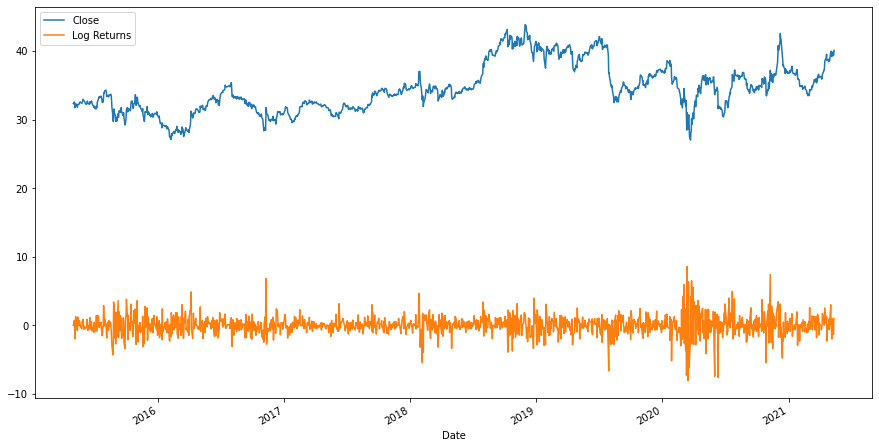

In [93]:
_ = prices.plot(figsize=(15, 8))

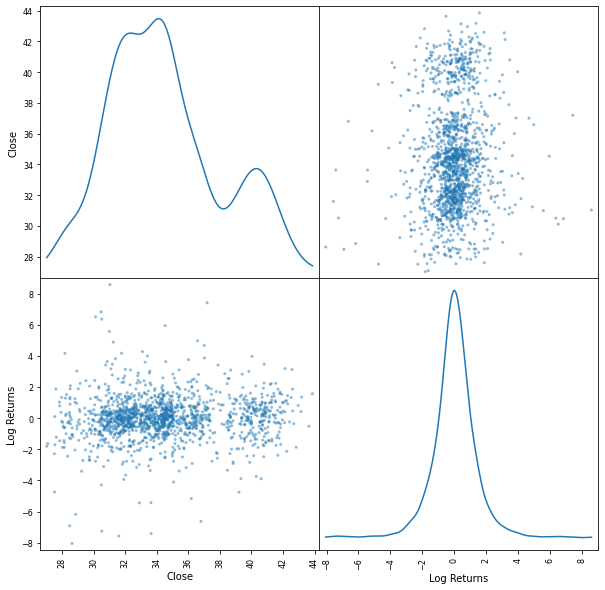

In [94]:
_ = scatter_matrix(prices, figsize=(10, 10), diagonal='kde')

In [42]:
#Log returns
log_returns.describe()

,Log Returns
count,1520.000000
mean,0.014162
std,1.393204
min,-8.050144
25%,-0.599996
50%,0.000000
75%,0.649866
max,8.581704


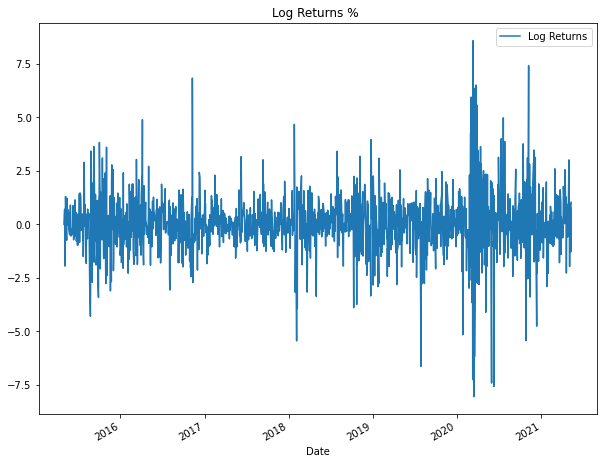

In [95]:
_ = log_returns.plot(figsize=(10, 8), title = "Log Returns % ")

In [96]:
def autocorrelation_plt(dataframe):
  
  """
  Function to compute autocorrelation plot 

  :param dataframe: dataframe (of floats) of time-series
  :output: plot with y axis as autocorrelation and x axis as lag
  """

  fig = plt.figure()
  fig.set_figwidth(10)
  fig.set_figheight(8)

  for i in dataframe:
    _ = autocorrelation_plot(dataframe[i], label=i)
  _ = plt.legend(loc='upper right')

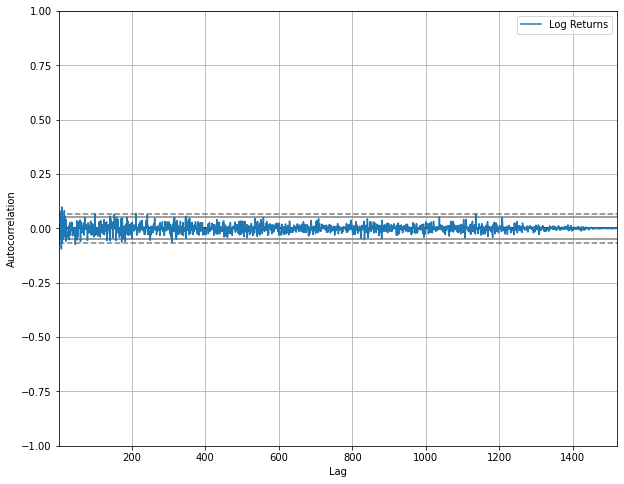

In [97]:
# Auto correlation of log returns 
# assumed to be close to zero for real time series (linear unpredictability)
autocorrelation_plt(log_returns) 

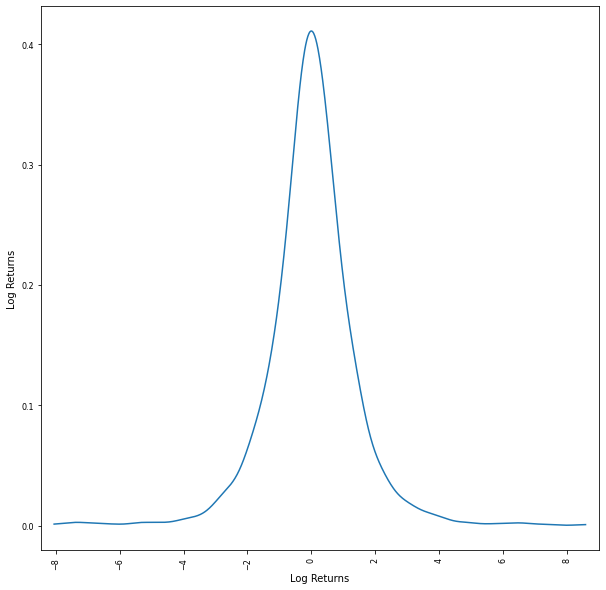

In [98]:
_ = scatter_matrix(log_returns, figsize=(10, 10), diagonal='kde')

In [99]:
# Cross correlation
log_returns.corr().iloc[:,0]

Log Returns    1.0
Name: Log Returns, dtype: float64

## Transform Data and Convert to Tensor

In [28]:
# Rolling window applied to dataframe before converting it to tensor
def rolling_window(data, window=32, stride=1): 
    """
    takes an array and returns rolling window of inputs

    :data: array of values
    :window: size of window you would like each return input
    :stride: do we want to stride inputs 
    
    :return: array of windows
    """    
    x = []
    current = 0
    total = (len(data)/stride)-window
    for i in range(int(total)+1):
        x.append(data[current:current+window])
        current += stride
    return x

data = rolling_window(np.asarray(log_returns))
train_data = np.stack(data, axis=0)

# Convert to tensor
train_data = tf.convert_to_tensor(train_data, np.float32)
train_dataset = tf.data.Dataset.from_tensor_slices(train_data).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [115]:
train_dataset

<BatchDataset element_spec=TensorSpec(shape=(None, 32, 1), dtype=tf.float32, name=None)>

## Train the Model

In [29]:
# Input for the generator: some random noise, called latent data 
EPOCHS = 10
num_examples_to_generate = 16 # maximum value due to plotting 
seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [30]:
test = [[plot_hist, seed]]

In [31]:
# Global variables for the loss
G_loss = []; D_loss = [];

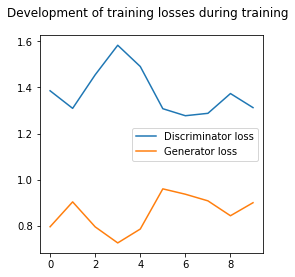

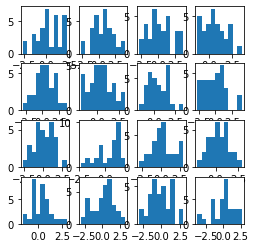

Time for epoch 10 is 1.7979745864868164 sec


In [32]:
# Train the data
train(train_dataset, test, EPOCHS, choice)

## Model evaluation

In [46]:
# Using the trained generator to compute new synthetic data

# Getting generated data
noise = np.random.randn(32,100)
predictions = generator(noise, training=True) # TRAINING TRUE OR FALSE

result = tf.squeeze(predictions) # Given a tensor input, this operation returns a tensor of the same type with all dimensions of size 1 removed.
temp = (result.numpy())
generated_data = [item for sublist in temp for item in sublist] # temp is the list getting flattened

df_generated = pd.DataFrame(generated_data,columns=['Generated Data'])
#df_generated.describe()

In [65]:
np.random.randn(157,100)

array([[ 0.0893992 ,  1.06982454,  1.10369491, ...,  1.76116968,
         0.29220141, -1.21383604],
       [ 1.16508754,  0.5846231 ,  0.53377476, ..., -0.65845209,
         0.09221363,  0.31916254],
       [ 1.11957182, -0.05213798,  0.08054744, ...,  0.53593449,
        -0.57323076,  0.12072815],
       ...,
       [-0.08896543, -0.51146569,  0.90112374, ..., -0.32605329,
         1.99363125, -0.85706042],
       [ 0.55512938, -0.67484882,  1.70845756, ..., -0.54545333,
        -0.2557208 ,  0.47271265],
       [ 0.10100198,  0.59211068, -0.75717861, ...,  1.43552401,
         0.74640767, -0.20246634]])

In [45]:
1032/32

32.25

In [47]:
df_generated #dimension = 157*32(dimension)

,Generated Data
0,1.562847
1,0.925780
2,-2.299895
3,2.009425
4,0.813524
...,...
1019,1.437238
1020,0.448338
1021,1.623965
1022,1.963933


## KS-Test
This tests whether 2 samples are drawn from the same distribution. Note that the distribution is assumed to be continuous.

This is the two-sided test, one-sided tests are not implemented. The test uses the two-sided asymptotic Kolmogorov-Smirnov distribution.

If the K-S statistic is small or the p-value is high, then we cannot reject the hypothesis that the distributions of the two samples are the same.


## Plots
Generated vs Original log returns

In [48]:
stats.ks_2samp(log_returns.iloc[:,0],generated_data) # comparing real data to synthetic data

KstestResult(statistic=0.12598684210526315, pvalue=6.309753941557972e-09)

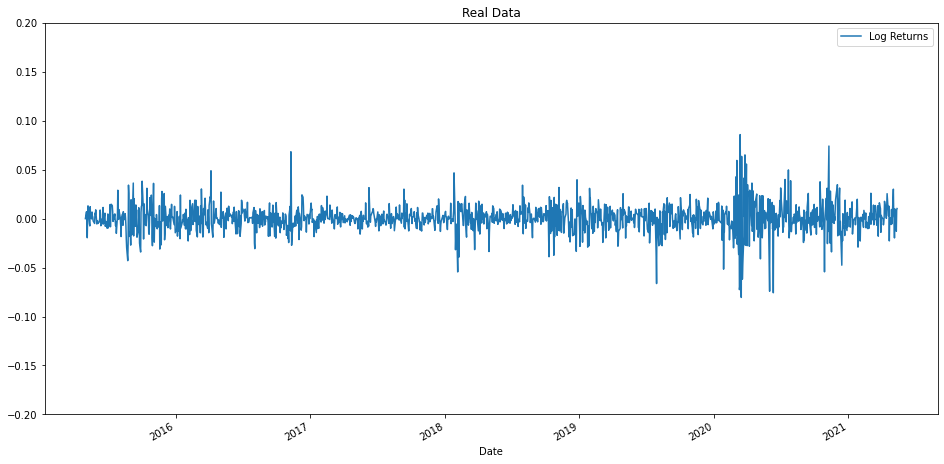

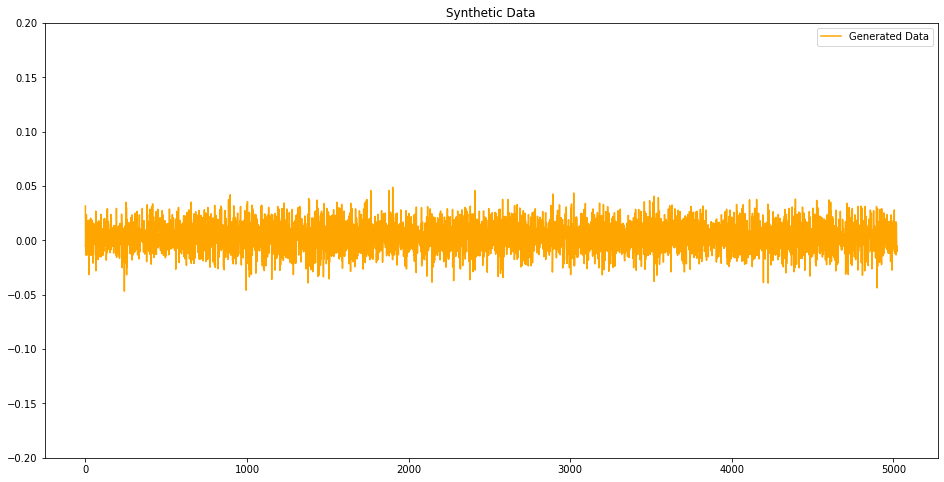

In [49]:
noise = np.random.randn(157,100)
predictions = generator(noise, training=True) # TRAINING TRUE OR FALSE
result = tf.squeeze(predictions) # Given a tensor input, this operation returns a tensor of the same type with all dimensions of size 1 removed.
temp = (result.numpy())
generated_data = [item for sublist in temp for item in sublist] # temp is the list getting flattened
df_generated = pd.DataFrame(generated_data,columns=['Generated Data'])


# put them overlapping?
log_returns.div(100).plot(title = "Real Data",ylim=[-0.2,0.2],figsize=(16, 8))
df_generated.div(100).plot(title = "Synthetic Data",ylim=[-0.2,0.2],style="orange",figsize=(16, 8))

plt.show()

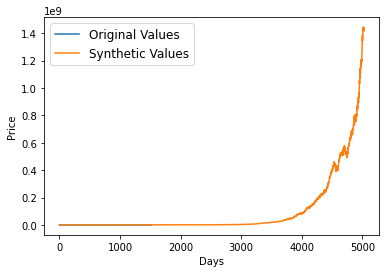

In [50]:
noise = np.random.randn(157,100)
predictions = generator(noise, training=True) # TRAINING TRUE OR FALSE
result = tf.squeeze(predictions) # Given a tensor input, this operation returns a tensor of the same type with all dimensions of size 1 removed.
temp = (result.numpy())
generated_data = [item for sublist in temp for item in sublist] # temp is the list getting flattened
df_generated = pd.DataFrame(generated_data,columns=['Generated Data'])

df12 = df_generated.div(100) # divide by 100 to compensate for training input (x100)
df12.iloc[0, 0] = 0
df13 = df12.iloc[:,0].tolist()
price0 = 1283 # arbitrary value  1335 on 01.01.2001
df = pd.DataFrame(df13, columns = ['logreturns'])
df["logr_na0"] = df.logreturns.fillna(0)
df['cumlog'] = np.cumsum(df.logr_na0)
df["norm"] = np.exp(df.cumlog)
df["prices_back"] = price0 * df.norm

list_generated = df.iloc[:,4].tolist()
list_original = prices.iloc[:,0].tolist()
plt.plot(list_original, label= "Original Values")
plt.plot(list_generated, label= "Synthetic Values")
plt.xlabel("Days")
plt.ylabel("Price")
plt.legend(fontsize=12)
plt.show()

In [51]:
df_generated

,Generated Data
0,2.733203
1,-1.406723
2,-0.693383
3,0.182761
4,0.324670
...,...
5019,-0.159305
5020,-1.160632
5021,0.788043
5022,1.287779


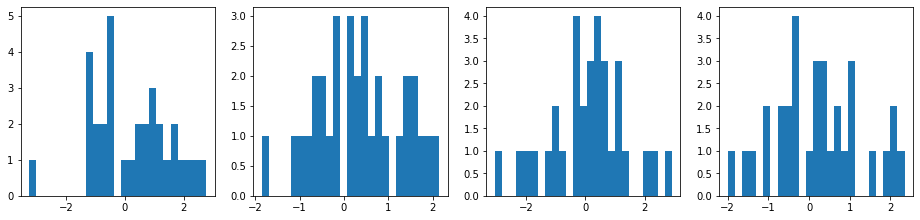

In [52]:
noise_dim = 100
num_examples_to_generate = 4
test_input = tf.random.normal([num_examples_to_generate, noise_dim])
pred = generator(test_input, training=False) # training = False because we are working on the already trained generator
def plot_histogram(predictions):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).

  fig = plt.figure(figsize=(16,16))
  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      # plt.plot(predictions[i, :, 0])
      # plt.axis('off')
      plt.hist(predictions[i, :, 0],bins= 25 ) ## temp

  # plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

plot_histogram(pred)

(0.0, 2000.0)

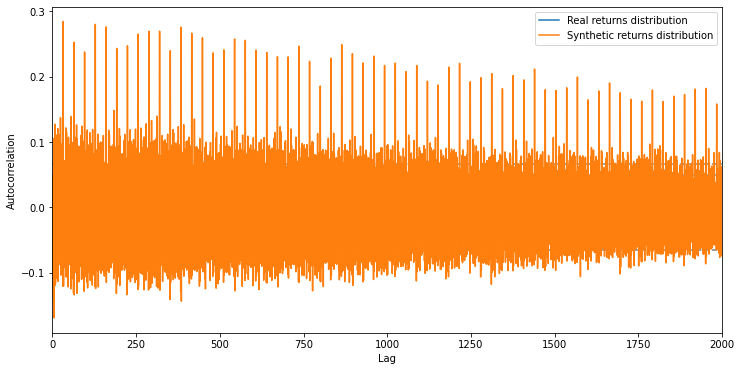

In [53]:
#ACF 
fig, (ax2) = plt.subplots(1, 1, figsize=(12,6))
pd.plotting.autocorrelation_plot(log_returns,label='Real returns distribution', ax=ax2).set_xlim([0, 2000])
pd.plotting.autocorrelation_plot(generated_data, ax=ax2,label='Synthetic returns distribution').set_xlim([0, 2000])

(0.0, 2000.0)

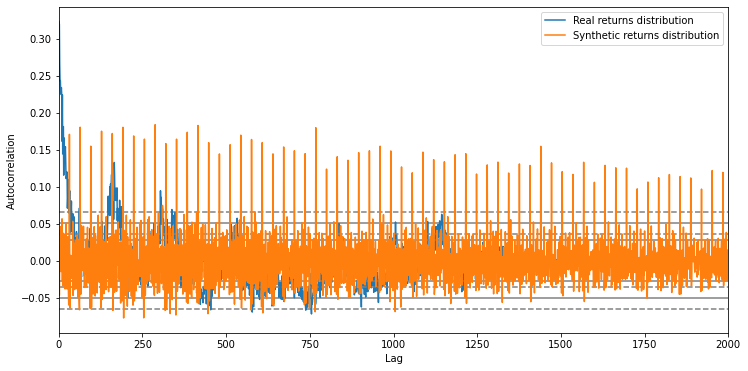

In [54]:
# ACF of absolute returns
fig, (ax2) = plt.subplots(1, 1, figsize=(12,6))
pd.plotting.autocorrelation_plot(np.abs(log_returns),label='Real returns distribution', ax=ax2).set_xlim([0, 2000])
pd.plotting.autocorrelation_plot(np.abs(generated_data), ax=ax2,label='Synthetic returns distribution').set_xlim([0, 2000])

## Empirical PDF
When the PDF is graphically portrayed, the area under the curve will indicate the interval in which the variable will fall. The total area in this interval of the graph equals the probability of a discrete random variable occurring. More precisely, since the absolute likelihood of a continuous random variable taking on any specific value is zero due to the infinite set of possible values available, the value of a PDF can be used to determine the likelihood of a random variable falling within a specific range of values.

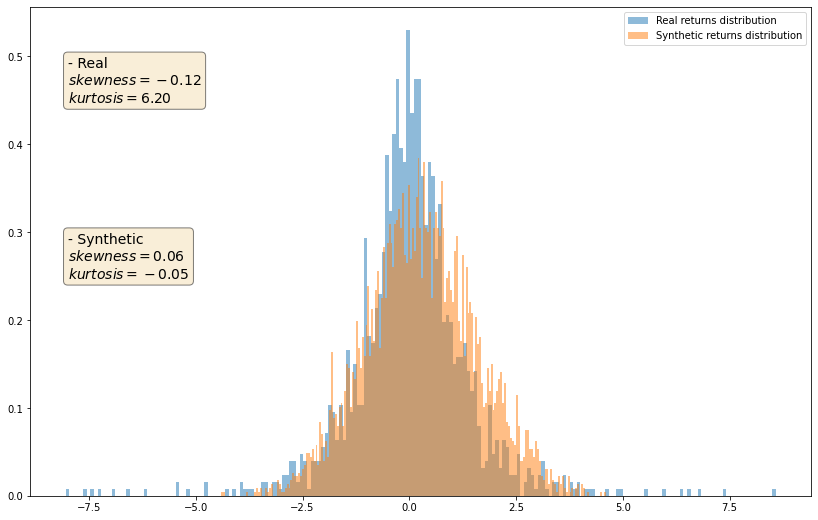

In [55]:
# Comparing the distribution of real and generated (synthetic) data
# PDFs show the probability of observing a value within a specific range
def empirical_pdf(real, syntethic):
  fig, (ax2) = plt.subplots(1, 1, figsize=(14,9))
  ax2.hist(real, density=True, bins=200,alpha=0.5,label='Real returns distribution')
  ax2.hist(syntethic, density=True, bins=200,alpha=0.5,label='Synthetic returns distribution')
  ax2.legend(loc='upper right')

  textstr = '\n'.join((
      r'%s' % ("- Real",),
      # t'abs_metric=%.2f' % abs_metric
      r'$skewness=%.2f$' % (skew(real),),
      r'$kurtosis=%.2f$' % (kurtosis(real),))
  )
  props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
  ax2.text(
      -8, 0.5, textstr,
      fontsize=14,
      verticalalignment='top',
      bbox=props
  )
  textstr = '\n'.join((
      r'%s' % ("- Synthetic",),
      # t'abs_metric=%.2f' % abs_metric
      r'$skewness=%.2f$' % (skew(syntethic),),
      r'$kurtosis=%.2f$' % (kurtosis(syntethic),))
  )
  ax2.text(
      -8, 0.3, textstr, 
      fontsize=14,
      verticalalignment='top',
      bbox=props
  )

empirical_pdf(log_returns.iloc[:,0], generated_data)

Skewness and Kurtosis

Skewness is a measure of the asymmetry of the probability distribution of a real-valued random variable about its mean. The skewness value can be positive, zero, negative, or undefined.偏度是衡量一个实值随机变量的概率分布对其平均值的不对称性。偏度值可以是正的、零的、负的或未定义的。


Kurtosis is a measure that defines how heavily the tails of a distribution differ from the tails of a normal distribution. In other words, kurtosis identifies whether the tails of a given distribution contain extreme values.峰度是一种测量方法，它定义了分布的尾部与正常分布的尾部有多大的差异。换句话说，峰度确定了一个给定分布的尾部是否包含极端值。

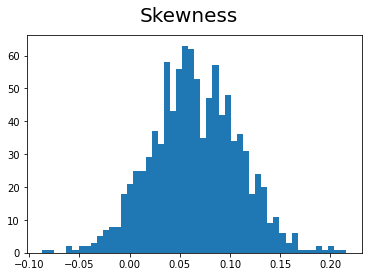

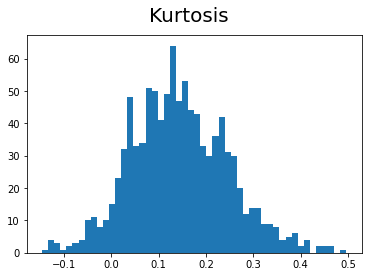

In [56]:
sk = []
flt = []
for i in range(0,1000):
  noise = np.random.randn(111,100)
  result = generator(noise)
  result = tf.squeeze(result)
  temp = (result.numpy())
  generated_data = [item for sublist in temp for item in sublist] 
  sk.append(skew(generated_data))
  flt.append(kurtosis(generated_data))

fig = plt.figure()
fig.suptitle('Skewness', fontsize=20)
plt.hist(sk, bins=50)

fig = plt.figure()
fig.suptitle('Kurtosis', fontsize=20)
plt.hist(flt, bins=50)
plt.show()